# TABLE OF CONTENTS

## [Part 1: Creating databases, schemas and tables (Task 1)](#part-1--creating-databases-schemas-and-tables)
* [Create database](#11-create-database---fcpgitdb)
* [Create schema](#12-create-schema---fcp)
* [Create tables - GitData](#13-create-table-based-on-gitdata)
    * [Commit data](#131-create-a-table---fcpdbgitcommit-commit-data)
    * [Files data](#132-create-table---fcpdbgitcommitfile-file-data)
* [Creating tables - GitIssues](#14-create-table-based-on-gitissues)
    * [Before comment ID](#141-create-table---fcpdbgitissue-before-commentid)
    * [After comment ID](#142-create-table---fcpdbgitissuecommentafter-commentid)
## [Part 2: Read, clean and load database (Task 2)](#part-2-read-clean-and-load-database)
* [Reading GitData](#21-reading-gitdata)
* [Cleaning and feature engineering (GitData)](#22-data-cleaning-and-feature-engineering-gitdata)
    * [Cleaning datetime](#221-cleaning-datetime)
    * [Adding timezone to datetime](#222-adding-a-timezone-to-datetime)
    * [Converting into integer](#223-converting-some-columns-into-an-integer)
* [Reading GitIssues](#23-reading-gitissues)
* [Cleaning and feature engineering (GitIssues)](#24-data-cleaning-and-feature-engineering-gitissues)
    * [Adding issue ID](#241-creating-issue-id)
    * [Converting string to datetime](#242-converting-string-columns-into-datetime)
* [Loading postgres table](#25-loading-postgres-table)
    * [Git commit table](#251-gitcommit-table)
    * [Git commit_file table](#252-gitcommitfile-table)
    * [Git issue table](#253-gitissue-table)
    * [Git issue_comment table](#254-gitissuecomment-table)
## [Part 3: Descriptive insights (Task 2)](#part-3-descriptive-insights)
* [Total commint count](#31-total-commit-count-by-project)
* [Total number of files and lines of code](#32-total-number-of-files-and-number-of-lines-of-code)
* [Number of author comparison](#33-number-of-author-comparison)
* [Number of authors by region](#34-number-of-authors-based-on-region-timezone)
* [Work hour distribution](#35-work-hour-distribution)
    * [Based on author hour](#351-author-hour-distribution)
    * [Based on committer hour](#352-committer-hour-distribution)
* [Top Authors](#36-top-authors)
    * [Based on lines of code (Pytorch)](#361-top-authors---number-of-lines-of-code-pytorch)
    * [Based on lines of code (Tensorflow)](#362-top-authors---number-of-lines-of-code-tensorflow)
* [File change type](#37-file-change-type)
    * [Overview](#371-overview-of-file-changes-based-on-type-of-change)
    * [Files added](#372-file-added-based-on-date)
    * [Files modified](#373-files-modified-by-date)
* [Issues](#38-issues)
    * [Number of issues found](#381-number-of-issues-found-by-date)
    * [Time taken to fix issues](#382-issues-fix-time)
    * [Issues reported](#383-users-that-report-the-most-issues)
    * [Issues closer](#384-users-that-close-the-most-issues)
    * [Issues commenter](#385-top-issue-commenter)
    * [Issue labels](#386-top-issue-labels)
## [Part 4: Using Pyspark for analysis (Task 3)](#part-4-pyspark)
* [Data preparation](#41-prepare-weekly-issue-aggregation)
* [Model](#42-prepare-model-dataset)
* [Feature vector](#43-generating-a-feature-vector)
* [Linear regression model](#44-fitting-a-linear-regression-model)
* [Prediction](#45-preparing-prediction-features)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Importing packages and naming connection parameters

In [1]:
import pandas as pd
import psycopg2

pd.set_option("display.max_columns",None)

In [2]:
# Connection params
dbname = "postgres"
user = "postgres"
password = "password"
host = "localhost"
port = "5432"

# Part 1 : Creating databases, schemas and tables
#### *Task 1 of the assignment*
###### [Back to TOC](#table-of-contents)

## 1.1: Create database - fcp_gitdb

In [3]:
# CREATE DATABASE
try:
    connection = psycopg2.connect(dbname=dbname,
                            user=user,
                            password=password,
                            host=host,
                            port=port)

    # Set autocommit
    connection.autocommit = True
    cursor = connection.cursor()

    # Create a new database
    cursor.execute("CREATE DATABASE fcp_gitdb;")
    print(cursor.statusmessage)


except psycopg2.Error as error:
    print("Warning!", error)

finally:
        if connection is not None:
            cursor.close()
            connection.close()

CREATE DATABASE


## 1.2: Create schema - fcp

In [4]:
# Set the new db
dbname = 'fcp_gitdb'

# Connect to fcp_gitdb and perform some tasks
try:
    connection = psycopg2.connect(dbname=dbname,
                            user=user,
                            password=password,
                            host=host,
                            port=port)
    cursor = connection.cursor()

    # Create a schema
    cursor.execute("CREATE SCHEMA fcp;")

    print(cursor.statusmessage, '\n')
    
    connection.commit()

except psycopg2.Error as error:
    print("Warning!", error)
    
finally:
        if connection is not None:
            cursor.close()
            connection.close()

CREATE SCHEMA 



## 1.3: Create table (based on GitData)

##### gitData: In this csv file, two tables can be divided:
    1. commit data
    2. files data
##### Look carefully at the data:
Before the files field, all of which are about commit-related data. A commit may involve multiple files, so when the same commit involves multiple files, the content of the fields before the files is repeated, hence it is more appropriate to build a separate table to prevent overlap.

Then the fields before files can use the hash field as the primary key, but the fields after it have no primary key, we give each file a unique id as the primary key

## 1.3.1 Create a table - fcp_db.git_commit (commit data)

In [5]:

# Connect to fcp_db and perform some tasks
try:
    connection = psycopg2.connect(dbname=dbname,
                            user=user,
                            password=password,
                            host=host,
                            port=port)
    cursor = connection.cursor()

    # Create a table storing git_commit info
    cursor.execute("""
        CREATE TABLE fcp.git_commit (
            hash char(40) primary key, 
            msg  text,
            author_name  varchar(255),
            committer_name varchar(255),
            author_date timestamp,
            author_timezone integer,
            committer_date timestamp,
            committer_timezone integer,
            branches varchar(15),
            in_main_branch boolean,
            merge boolean,
            parents char(40),
            project_name varchar(10),
            deletions integer,
            insertions integer,
            lines integer,    
            files integer
        );
    """)

    print(cursor.statusmessage, '\n')
    connection.commit()

except psycopg2.Error as error:
    print("Warning!", error)
    
finally:
        if connection is not None:
            cursor.close()
            connection.close()

CREATE TABLE 



## 1.3.2: Create table - fcp_db.git_commit_file (file data)

In [6]:

# Connect to fcp_db and perform some tasks
try:
    connection = psycopg2.connect(dbname=dbname,
                            user=user,
                            password=password,
                            host=host,
                            port=port)
    cursor = connection.cursor()

    # Create a table storing git_commit info
    cursor.execute("""
        CREATE TABLE fcp.git_commit_file (
            file_id integer primary key, 
            hash char(40),
            old_path  text,
            new_path  text,
            filename  text,            
            change_type  varchar(15),            
            diff text,
            diff_parsed text,
            deleted_lines integer,
            source_code text,
            source_code_before text,            
            nloc integer,
            complexity integer,
            token_count integer, 
            constraint fk_git_commit_file_hash foreign key(hash)  references fcp.git_commit(hash)
        );
    """)

    print(cursor.statusmessage, '\n')
    connection.commit()

except psycopg2.Error as error:
    print("Warning!", error)
    
finally:
        if connection is not None:
            cursor.close()
            connection.close()

CREATE TABLE 



## 1.4: Create table (based on gitIssues)

##### Likewise, the data in the "Git-Issues" files can also be divided into 2 parts:
    1. The section before comment_id, which is a description of the issue.
    2. The section after comment_id, which is an annotation/comment on the issue, an issue can have multiple annotations/comments
    
 The information before comment_id, has no unique identifiers, we can use "title" and the "create_at" time to create a unique identifier for issue id as the primary key. The information after comment_id, references to comment_id as the primary key.

## 1.4.1: Create table - fcp_db.git_issue (before comment_id)

In [7]:

# Connect to fcp_db and perform some tasks
try:
    connection = psycopg2.connect(dbname=dbname,
                            user=user,
                            password=password,
                            host=host,
                            port=port)
    cursor = connection.cursor()

    # Create a table storing git_issue
    cursor.execute("""
        CREATE TABLE fcp.git_issue (
            issue_id integer primary key, 
            title text,
            state  varchar(10),
            body  text,
            "user"  varchar(50),  
            user_id  varchar(50),              
            created_at  timestamp ,
            updated_at  timestamp ,    
            closed_at  timestamp ,                
            assignees text,
            labels text,
            reactions text,
            n_comments integer,
            closed_by varchar(50),  
            project varchar(10)
        );
    """)

    print(cursor.statusmessage, '\n')
    connection.commit()

except psycopg2.Error as error:
    print("Warning!", error)
    
finally:
        if connection is not None:
            cursor.close()
            connection.close()

CREATE TABLE 



## 1.4.2: Create table - fcp_db.git_issue_comment(after comment_id)

In [8]:

# Connect to fcp_db and perform some tasks
try:
    connection = psycopg2.connect(dbname=dbname,
                            user=user,
                            password=password,
                            host=host,
                            port=port)
    cursor = connection.cursor()

    # Create a table storing git_issue_comment
    cursor.execute("""
        CREATE TABLE fcp.git_issue_comment (
            comment_id int primary key,
            issue_id integer, 
            comment_created_at  timestamp ,
            comment_updated_at timestamp ,
            comment_user_id varchar(50),  
            comment_user varchar(50),  
            comment_text text,
            constraint fk_git_issue_comment_issueid foreign key(issue_id)  references fcp.git_issue(issue_id)
        );
    """)

    print(cursor.statusmessage, '\n')
    connection.commit()

except psycopg2.Error as error:
    print("Warning!", error)
    
finally:
        if connection is not None:
            cursor.close()
            connection.close()

CREATE TABLE 



# Part 2: Read, Clean and Load Database
#### *Task 1 of the assignment*
###### [Back to TOC](#table-of-contents)

## 2.1: Reading GitData

In [9]:
df_gitdata=pd.read_csv("data/gitData.csv",low_memory=False,index_col=[0])

# drop duplicated records
df_gitdata=df_gitdata.drop_duplicates()

# generate a file id
df_gitdata=df_gitdata.reset_index(drop=True)
df_gitdata["file_id"]=df_gitdata.index

# df_gitdata.head()

## 2.2: Data cleaning and feature engineering (GitData)

### 2.2.1: Cleaning datetime

In [10]:
# define function to clean datetime

def conver_seconds_to_tz(s):
    pos_neg='+' if s>=0 else '-'    
    tz="{}{}".format(pos_neg,str(int(abs(s)/3600)).zfill(2))    
    
    return tz

def gen_datetime_tz(dt,s):
    tz=conver_seconds_to_tz(s)
    return pd.to_datetime("{}{}".format(dt, tz))


### 2.2.2: Adding a timezone to datetime

In [11]:
# add timezone to datetime

# df_gitdata["author_date"]=df_gitdata.apply(lambda row: gen_datetime_tz(row["author_date"], row["author_timezone"]),axis=1)
# df_gitdata["committer_date"]=df_gitdata.apply(lambda row: gen_datetime_tz(row["committer_date"], row["committer_timezone"]),axis=1)

df_gitdata["author_date"]=pd.to_datetime(df_gitdata["author_date"])
df_gitdata["committer_date"]=pd.to_datetime(df_gitdata["committer_date"])

# clean parents
df_gitdata["parents"]=df_gitdata["parents"].map(lambda x: eval(x)[0] if len(eval(x))==1 else '')

# clean branches
df_gitdata["branches"]=df_gitdata["branches"].map(lambda x: eval(x)[0] )

### 2.2.3: Converting some columns into an integer

In [12]:
# convert to integer

df_gitdata['nloc']=df_gitdata['nloc'].fillna(0).astype(int)
df_gitdata['complexity']=df_gitdata['complexity'].fillna(0).astype(int)
df_gitdata['token_count']=df_gitdata['token_count'].fillna(0).astype(int)
df_gitdata['file_id']=df_gitdata['file_id'].fillna(0).astype(int)
df_gitdata['deleted_lines']=df_gitdata['deleted_lines'].fillna(0).astype(int)

In [13]:
df_gitdata.head(2)

,hash,msg,author_name,committer_name,author_date,author_timezone,committer_date,committer_timezone,branches,in_main_branch,merge,parents,project_name,deletions,insertions,lines,files,old_path,new_path,filename,change_type,diff,diff_parsed,deleted_lines,source_code,source_code_before,nloc,complexity,token_count,file_id
0,e318058ffe662d426617a405fb21e6470dfc1219,Ignore LNK4099 for debug binary libtorch build...,Jane Xu,Facebook GitHub Bot,2021-07-23 16:27:24,25200,2021-07-23 16:31:41,25200,master,True,False,04c95a063857851fe15956baf80e6b30bc8b3dad,pytorch,3,3,6,2,CMakeLists.txt,CMakeLists.txt,CMakeLists.txt,MODIFY,"@@ -485,7 +485,7 @@ if(MSVC)\n foreach(flag_...","{'added': [[488, ' string(APPEND ${flag_var...",1,cmake_minimum_required(VERSION 3.5 FATAL_ERROR...,cmake_minimum_required(VERSION 3.5 FATAL_ERROR...,0,0,0,0
1,e318058ffe662d426617a405fb21e6470dfc1219,Ignore LNK4099 for debug binary libtorch build...,Jane Xu,Facebook GitHub Bot,2021-07-23 16:27:24,25200,2021-07-23 16:31:41,25200,master,True,False,04c95a063857851fe15956baf80e6b30bc8b3dad,pytorch,3,3,6,2,cmake/MiscCheck.cmake,cmake/MiscCheck.cmake,MiscCheck.cmake,MODIFY,"@@ -258,9 +258,9 @@ if(${CMAKE_CXX_COMPILER_ID...","{'added': [[261, ' ""${CMAKE_SHARED_LINKER...",2,"if(UNIX)\n # prevent Unknown CMake command ""c...","if(UNIX)\n # prevent Unknown CMake command ""c...",0,0,0,1


## 2.3: Reading GitIssues

In [14]:
df_gitIssues=pd.read_csv("data/gitIssues.csv",low_memory=False,index_col=[0])
df_gitIssues.head(2)

,title,state,body,user,user_id,repository,created_at,updated_at,closed_at,assignees,labels,reactions,n_comments,closed_by,comment_id,comment_created_at,comment_updated_at,comment_user_id,comment_user,comment_text,project
0,Feature Request: Add Pixel Unshuffle,closed,I would like to propose the addition of an inv...,hinthornw,MDQ6VXNlcjEzMzMzNzI2,NaN,2017-08-16 05:09:55,2021-01-14 00:03:06,2021-01-11 04:38:15,[],"['module: nn', 'triaged', 'module: vision', 'f...","['+1', '+1', '+1', '+1', '+1', '+1', '+1', '+1...",11,Mike Ruberry,326121859,2017-08-30 21:17:02,2017-08-30 21:17:02,MDQ6VXNlcjEzMTA1NzA=,soumith,@alykhantejani (as the man behind PixelShuffle...,pytorch
1,Feature Request: Add Pixel Unshuffle,closed,I would like to propose the addition of an inv...,hinthornw,MDQ6VXNlcjEzMzMzNzI2,NaN,2017-08-16 05:09:55,2021-01-14 00:03:06,2021-01-11 04:38:15,[],"['module: nn', 'triaged', 'module: vision', 'f...","['+1', '+1', '+1', '+1', '+1', '+1', '+1', '+1...",11,Mike Ruberry,326360939,2017-08-31 17:07:44,2017-08-31 17:07:44,MDQ6VXNlcjY4NzE5NA==,alykhantejani,@hinthornw This sounds like something for a py...,pytorch


## 2.4: Data cleaning and feature engineering (GitIssues)

### 2.4.1: Creating issue ID

In [16]:
# add issue id

df_gitIssues_id=df_gitIssues[["title","created_at"]].drop_duplicates().reset_index(drop=True)
df_gitIssues_id["issue_id"]=df_gitIssues_id.index

df_gitIssues=pd.merge(df_gitIssues, df_gitIssues_id,on=["title","created_at"])
df_gitIssues.head(2)

,title,state,body,user,user_id,repository,created_at,updated_at,closed_at,assignees,labels,reactions,n_comments,closed_by,comment_id,comment_created_at,comment_updated_at,comment_user_id,comment_user,comment_text,project,issue_id
0,Feature Request: Add Pixel Unshuffle,closed,I would like to propose the addition of an inv...,hinthornw,MDQ6VXNlcjEzMzMzNzI2,NaN,2017-08-16 05:09:55,2021-01-14 00:03:06,2021-01-11 04:38:15,[],"['module: nn', 'triaged', 'module: vision', 'f...","['+1', '+1', '+1', '+1', '+1', '+1', '+1', '+1...",11,Mike Ruberry,326121859,2017-08-30 21:17:02,2017-08-30 21:17:02,MDQ6VXNlcjEzMTA1NzA=,soumith,@alykhantejani (as the man behind PixelShuffle...,pytorch,0
1,Feature Request: Add Pixel Unshuffle,closed,I would like to propose the addition of an inv...,hinthornw,MDQ6VXNlcjEzMzMzNzI2,NaN,2017-08-16 05:09:55,2021-01-14 00:03:06,2021-01-11 04:38:15,[],"['module: nn', 'triaged', 'module: vision', 'f...","['+1', '+1', '+1', '+1', '+1', '+1', '+1', '+1...",11,Mike Ruberry,326360939,2017-08-31 17:07:44,2017-08-31 17:07:44,MDQ6VXNlcjY4NzE5NA==,alykhantejani,@hinthornw This sounds like something for a py...,pytorch,0


### 2.4.2: Converting string columns into datetime

In [17]:
# convert string to datetime

df_gitIssues['created_at']=pd.to_datetime(df_gitIssues['created_at'])
df_gitIssues['updated_at']=pd.to_datetime(df_gitIssues['updated_at'])
df_gitIssues['closed_at']=pd.to_datetime(df_gitIssues['closed_at'])

df_gitIssues['comment_created_at']=pd.to_datetime(df_gitIssues['comment_created_at'])
df_gitIssues['comment_updated_at']=pd.to_datetime(df_gitIssues['comment_updated_at'])

In [18]:
# # conver str to list
# df_gitIssues['assignees']=df_gitIssues['assignees'].map(lambda x: eval(x))

# # conver str to list
# df_gitIssues['reactions']=df_gitIssues['reactions'].map(lambda x: eval(x))

# # conver str to list
# df_gitIssues['labels']=df_gitIssues['labels'].map(lambda x: eval(x))

## 2.5: Loading postgres table

### 2.5.1: git_commit table

In [19]:
commit_columns=['hash', 'msg', 'author_name', 'committer_name', 'author_date','author_timezone', 'committer_date', 'committer_timezone', 'branches', 'in_main_branch', 
                'merge', 'parents', 'project_name', 'deletions',   'insertions', 'lines', 'files']

df_commit=df_gitdata[commit_columns].drop_duplicates()
values = list(zip(*map(df_commit.get, df_commit)))

try:
    connection = psycopg2.connect(dbname=dbname,
                            user=user,
                            password=password,
                            host=host,
                            port=port)
    cursor = connection.cursor()
    
    # SQL INSERT
    insert_sql = """INSERT INTO fcp.git_commit (hash, msg, author_name, committer_name, author_date, author_timezone, committer_date, 
                                                                            committer_timezone,branches,  in_main_branch, merge, parents, project_name, deletions, insertions, lines, files)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"""
    
    # Insert data
    for value in values:
        cursor.execute(insert_sql, value)
        # print(cursor.statusmessage)

    # Commit changes
    connection.commit()

except  psycopg2.Error as error:
    print("Warning!", error)

finally:
        if connection is not None:
            cursor.close()
            connection.close()

### 2.5.2: git_commit_file table

In [20]:

commit_file_columns=['file_id', 'hash', 'old_path', 'new_path', 'filename',  'change_type', 'diff', 'diff_parsed', 'deleted_lines',
                     'source_code', 'source_code_before', 'nloc', 'complexity', 'token_count' ]

df_commit_file=df_gitdata[commit_file_columns].copy()

values = list(zip(*map(df_commit_file.get, df_commit_file)))

try:
    connection = psycopg2.connect(dbname=dbname,
                            user=user,
                            password=password,
                            host=host,
                            port=port)
    cursor = connection.cursor()
    
    # SQL INSERT
    insert_sql = """INSERT INTO fcp.git_commit_file (file_id, hash, old_path, new_path, filename, change_type, diff, diff_parsed, deleted_lines, 
                                                                                   source_code, source_code_before, nloc, complexity, token_count)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"""
    
    # Insert data
    for value in values:
        cursor.execute(insert_sql, value)

    # Commit changes
    connection.commit()

except  psycopg2.Error as error:
    print("Warning!", error)
    print(value)

finally:
        if connection is not None:
            cursor.close()
            connection.close()

### 2.5.3: git_issue table

In [21]:
issue_columns=['issue_id', 'title', 'state', 'body', 'user', 'user_id', 'created_at',  'updated_at', 'closed_at', 'assignees',
                           'labels', 'reactions', 'n_comments','closed_by','project']

df_issue_columns=df_gitIssues[issue_columns].drop_duplicates()
values = list(zip(*map(df_issue_columns.get, df_issue_columns)))

try:
    connection = psycopg2.connect(dbname=dbname,
                            user=user,
                            password=password,
                            host=host,
                            port=port)
    cursor = connection.cursor()
    
    # SQL INSERT
    insert_sql = """INSERT INTO fcp.git_issue (issue_id, title, state, body, "user", user_id,  created_at, updated_at, closed_at, 
                                                                             assignees, labels, reactions, n_comments,closed_by,project)
    VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)"""
    
    # Insert data
    for value in values:
        cursor.execute(insert_sql, value)
        # print(cursor.statusmessage)

    # Commit changes
    connection.commit()

except  psycopg2.Error as error:
    print("Warning!", error)

finally:
        if connection is not None:
            cursor.close()
            connection.close()

### 2.5.4: git_issue_comment table

In [22]:
issue_comment_columns=['comment_id', 'issue_id', 'comment_created_at',  'comment_updated_at', 'comment_user_id', 'comment_user', 'comment_text']

df_issue_comment_columns=df_gitIssues[issue_comment_columns].drop_duplicates()
values = list(zip(*map(df_issue_comment_columns.get, df_issue_comment_columns)))

try:
    connection = psycopg2.connect(dbname=dbname,
                            user=user,
                            password=password,
                            host=host,
                            port=port)
    cursor = connection.cursor()
    
    # SQL INSERT
    insert_sql = """INSERT INTO fcp.git_issue_comment (comment_id, issue_id, comment_created_at, comment_updated_at, comment_user_id, 
                                                                         comment_user, comment_text)
    VALUES (%s, %s, %s, %s, %s, %s, %s)"""
    
    # Insert data
    for value in values:
        cursor.execute(insert_sql, value)
        # print(cursor.statusmessage)

    # Commit changes
    connection.commit()

except  psycopg2.Error as error:
    print("Warning!", error)

finally:
        if connection is not None:
            cursor.close()
            connection.close()

# Part 3: Descriptive Insights
#### *Task 2 of the assignment*
###### [Back to TOC](#table-of-contents)

In [23]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns",None)
sns.set_palette('Set2')
sns.set_style('white')

In [24]:
connection = psycopg2.connect(dbname=dbname,
                            user=user,
                            password=password,
                            host=host,
                            port=port)

## 3.1: Total commit count by project

In [25]:
sql="""
    select project_name, count(hash) as number_of_commit
    from fcp.git_commit
    group by 1
"""

pd.read_sql(sql,connection)

,project_name,number_of_commit
0,pytorch,4514
1,text,66
2,elastic,10
3,tensorflow,9152
4,serve,382
5,vision,475
6,torchrec,94
7,audio,330
8,xla,101


##### The pdf states that this data is git data from pytorch tensorflow, but in actuality "project_name" contains other data, to use the data below, we must filter project_name in ('pytorch','tensorflow')

In [26]:

sql="""
    select project_name, committer_date::date as committer_date,count(hash) as number_of_commit
    from fcp.git_commit
    where project_name in('pytorch','tensorflow')
    group by 1,2
"""

df_daily_commit_num=pd.read_sql(sql,connection)
df_daily_commit_num['committer_date']=pd.to_datetime(df_daily_commit_num['committer_date'])
df_daily_commit_num.head()

,project_name,committer_date,number_of_commit
0,tensorflow,2021-11-14,7
1,pytorch,2021-09-10,30
2,pytorch,2021-10-19,54
3,pytorch,2021-10-05,33
4,tensorflow,2021-09-14,71


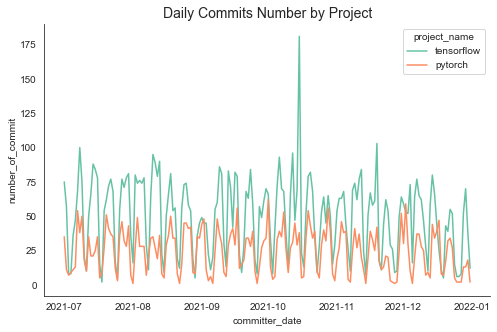

In [27]:
plt.figure(figsize=(8,5))
sns.lineplot(x="committer_date",y='number_of_commit',hue='project_name', data=df_daily_commit_num)
plt.title("Daily Commits Number by Project",fontsize=14)
sns.despine()

##### Tensorflow's commit count is much higher than Pytorch's throughout the duration from July 2021 to January of 2022. This could suggest that the Tensorflow's developers are much more active than the one at Pytorch. Or this could also suggest that Tensorflow has much more work to be done to be fully developed than Pytorch.

## 3.2: Total number of files and number of lines of code


##### Besides the commit count, we could also take a look at the file number and lines of code which could tell us more about each of the packages Tensorflow and Pytorch.

In [28]:
sql="""
    select project_name
    ,sum(lines) as total_lines
    ,sum(files) as total_files
    from fcp.git_commit
    where project_name in('pytorch','tensorflow')
    group by 1
    order by 1
"""

df_linefile_num=pd.read_sql(sql,connection)
df_linefile_num.head()

,project_name,total_lines,total_files
0,pytorch,1272451,24103
1,tensorflow,1614591,30641


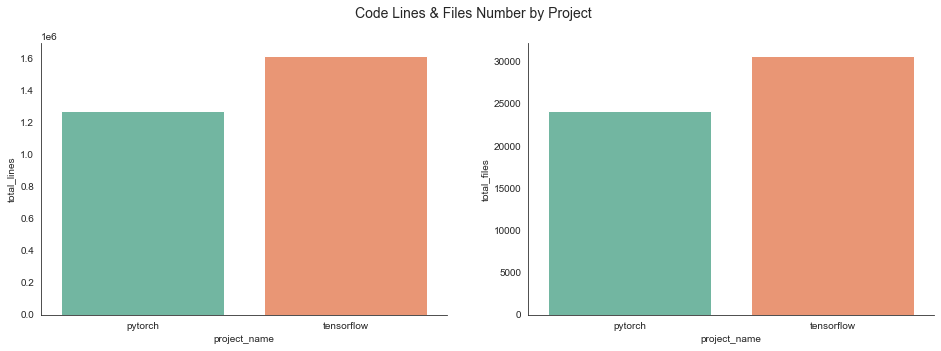

In [29]:
fig,axs=plt.subplots(1,2,figsize=(16,5))

sns.barplot(x='project_name',y='total_lines', data=df_linefile_num,ax=axs[0])
sns.barplot(x='project_name',y='total_files', data=df_linefile_num,ax=axs[1])

plt.suptitle("Code Lines & Files Number by Project",fontsize=14)
sns.despine()

##### Tensorflow developers have a greater workload than those of Pytorch based on the number of lines of code and number of files 

## 3.3: Number of author comparison

In [30]:
sql="""
    select project_name, count(distinct author_name) as number_of_author, count(distinct committer_name) as number_of_committer
    from fcp.git_commit
    where project_name in('pytorch','tensorflow')
    group by 1
    order by 1
"""

df_aucom_num=pd.read_sql(sql,connection)
df_aucom_num.head()

,project_name,number_of_author,number_of_committer
0,pytorch,532,1
1,tensorflow,456,164


##### Based on 3.2 we would assume that there would be a higher number of developers in Tensorflow as there is a higher workload. However it seems that there are more Pytorch developers than Tensorflow. We can then conclude that a single Tensorflow developer would have a higher amount of workload than the developers at Pytorch.

## 3.4: Number of authors based on region (timezone)

##### Although the data did not include geographical locations, there is a timezone difference. Based on this we can use the timezone differential to estimate the spread of programmers.

In [31]:
sql="""
    select project_name, author_timezone/3600 as author_timezone,count(distinct author_name) as number_of_author
    from fcp.git_commit
    where project_name in('pytorch','tensorflow')
    group by 1,2
    order by 1,2
"""

df_committer_num=pd.read_sql(sql,connection)
df_committer_num.head()

,project_name,author_timezone,number_of_author
0,pytorch,7,431
1,pytorch,8,254
2,tensorflow,-11,1
3,tensorflow,-10,2
4,tensorflow,-9,7


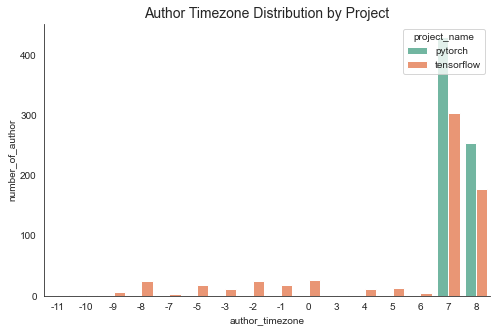

In [32]:
plt.figure(figsize=(8,5))
sns.barplot(x="author_timezone",y='number_of_author',hue='project_name', data=df_committer_num)
plt.title("Author Timezone Distribution by Project",fontsize=14)
sns.despine()

##### It seems that the developers of the two open source projects are mainly distributed in zone 7 and 8 (We can check which countries this zone has). In addition, Tensorflow developers are more widely distributed internationally as there are few authors in different timezones as compared to Pytorch which only has developers in zones 7 & 8.
##### A positive number should represent an eastern time zone, and a negative number should be a western time zone. The value mentioned in the title represents the number of seconds, hence  divide by 3600(sql)

## 3.5: Work hour distribution

##### To look at the time when developers have high workload

### 3.5.1 Author hour distribution

In [33]:
sql="""
    select project_name, extract(hour from author_date) as author_hour,count(hash) as number_of_commit
    from fcp.git_commit
    where project_name in('pytorch','tensorflow')
    group by 1,2
    order by 1,2
"""

df_author_hour=pd.read_sql(sql,connection)
df_author_hour["author_hour"]=df_author_hour["author_hour"].astype(int)
df_author_hour.head()

,project_name,author_hour,number_of_commit
0,pytorch,0,241
1,pytorch,1,225
2,pytorch,2,164
3,pytorch,3,143
4,pytorch,4,135


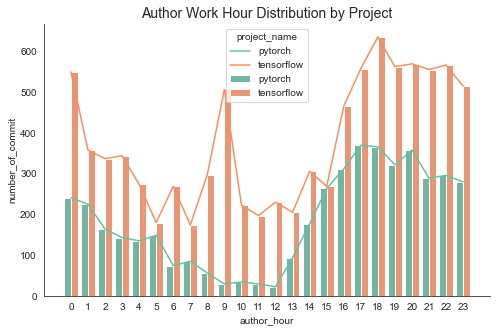

In [34]:
plt.figure(figsize=(8,5))
sns.barplot(x="author_hour",y='number_of_commit',hue='project_name', data=df_author_hour)
sns.lineplot(x="author_hour",y='number_of_commit',hue='project_name', data=df_author_hour)
plt.title("Author Work Hour Distribution by Project",fontsize=14)
sns.despine()

##### We can see a clear pattern for Pytorch, a decline in number of commits from hour 0 to hour 12 and then an increase from hour 13 to the peak in hour 17. Meanwhile Tensorflow's commit hours are more erratic, with a decline from hour 0 to 5 and rising back up to 500 commits in hour 9 and a sharp decline again only to reach its peak of 600 commits at hour 18. This can tell us that the developers of Pytorch work on the development of the OSS as a part-time job as there are more commits during certain hours. Meanwhile for Tensorflow, the developers on average have a higher commit throughout all hours meaning that they develop the software as a full-time job.

### 3.5.2: Committer hour distribution

In [35]:
sql="""
    select project_name, extract(hour from committer_date) as committer_hour,count(hash) as number_of_commit
    from fcp.git_commit
    where project_name in('pytorch','tensorflow')
    group by 1,2
    order by 1,2
"""

df_commit_hour=pd.read_sql(sql,connection)
df_commit_hour["committer_hour"]=df_commit_hour["committer_hour"].astype(int)
df_commit_hour.head()

,project_name,committer_hour,number_of_commit
0,pytorch,0,238
1,pytorch,1,226
2,pytorch,2,175
3,pytorch,3,147
4,pytorch,4,136


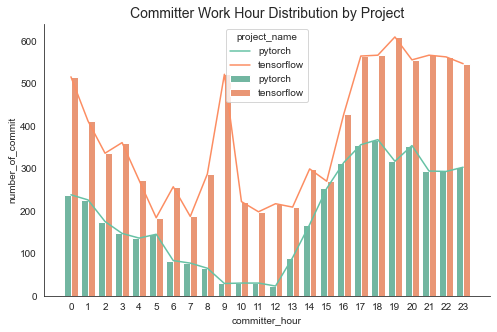

In [36]:
plt.figure(figsize=(8,5))
sns.barplot(x="committer_hour",y='number_of_commit',hue='project_name', data=df_commit_hour)
sns.lineplot(x="committer_hour",y='number_of_commit',hue='project_name', data=df_commit_hour)
plt.title("Committer Work Hour Distribution by Project",fontsize=14)
sns.despine()

##### The committer work hour distribution is similar to that of author work hour distribution. 

## 3.6: Top authors

##### Let's see who are the top 10 developers with the highest contribution
##### How do we measure contribution? Generally, the number of lines of code is used as an indicator (might not be optimal)

In [37]:
sql="""
select *
from
(
    select project_name, author_name,sum(lines) as workload
    ,rank()over(partition by project_name order by sum(lines) desc) as rnk
    from fcp.git_commit
    where project_name in('pytorch','tensorflow')
    group by 1,2
) tmp
where rnk<=10
"""

df_top10_authors=pd.read_sql(sql,connection)
df_top10_authors.head()

,project_name,author_name,workload,rnk
0,pytorch,jiej,160111,1
1,pytorch,Richard Barnes,91073,2
2,pytorch,Eli Uriegas,89503,3
3,pytorch,Shen Li,87022,4
4,pytorch,Zsolt Dollenstein,86191,5


### 3.6.1: Top authors - number of lines of code (PyTorch)

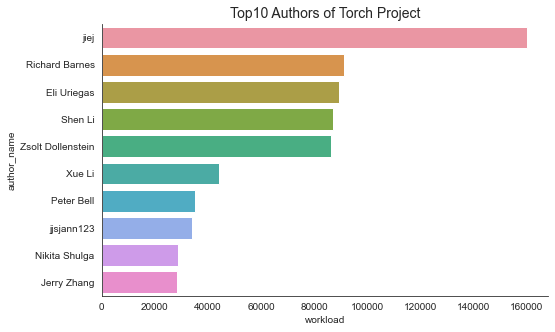

In [38]:
plt.figure(figsize=(8,5))
sns.barplot(y="author_name",x='workload', data=df_top10_authors[df_top10_authors["project_name"]=='pytorch'])
plt.title("Top10 Authors of Torch Project",fontsize=14)
sns.despine()

### 3.6.2: Top authors - number of lines of code (Tensorflow)

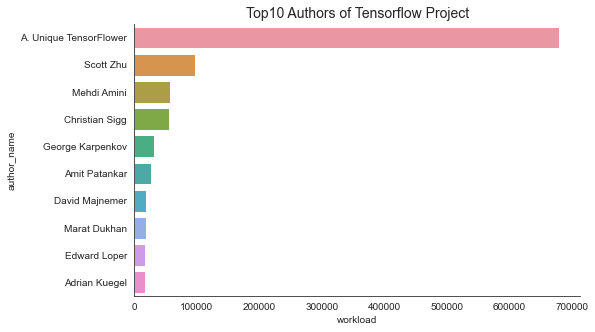

In [39]:
plt.figure(figsize=(8,5))
sns.barplot(y="author_name",x='workload', data=df_top10_authors[df_top10_authors["project_name"]=='tensorflow'])
plt.title("Top10 Authors of Tensorflow Project",fontsize=14)
sns.despine()

##### In contrast, the workload of the developers of tensorflow top1 is extremely prominent, while the other members of top10 are not much different.

## 3.7: File change type

+ Based on the changes in document, we do a comparison 

In [40]:
sql="""
    select project_name, change_type,count(a.hash) as number_of_file
    from fcp.git_commit a 
    join fcp.git_commit_file b
    on a.hash=b.hash
    
    where project_name in('pytorch','tensorflow')
    group by 1,2
    order by 1,2
"""

df_file_change=pd.read_sql(sql,connection)
df_file_change.head()

,project_name,change_type,number_of_file
0,pytorch,ADD,1363
1,pytorch,DELETE,500
2,pytorch,MODIFY,21817
3,pytorch,RENAME,136
4,tensorflow,ADD,2185


### 3.7.1: Overview of file changes based on type of change

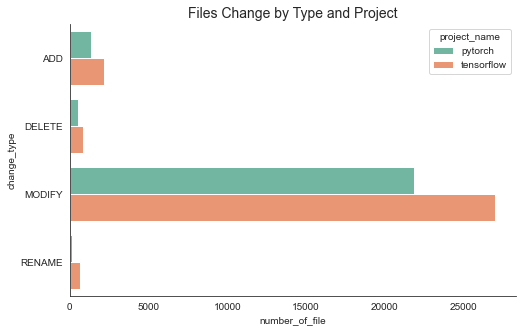

In [41]:
plt.figure(figsize=(8,5))
sns.barplot(y="change_type",x='number_of_file',hue='project_name', data=df_file_change)
plt.title("Files Change by Type and Project",fontsize=14)
sns.despine()

##### The main work of a developer is still to modify code, so let's add a time dimension to compare and see what the difference is

### 3.7.2: File added based on date

In [42]:
sql="""
    select project_name, committer_date::date as committer_date,count(a.hash) as number_of_file
    from fcp.git_commit a 
    join fcp.git_commit_file b
    on a.hash=b.hash
    
    where project_name in('pytorch','tensorflow')
    and change_type='ADD'
    group by 1,2
    order by 1,2
"""

df_file_add=pd.read_sql(sql,connection)
df_file_add['committer_date']=pd.to_datetime(df_file_add['committer_date'])
df_file_add.head()

,project_name,committer_date,number_of_file
0,pytorch,2021-07-01,5
1,pytorch,2021-07-02,7
2,pytorch,2021-07-03,6
3,pytorch,2021-07-06,12
4,pytorch,2021-07-07,7


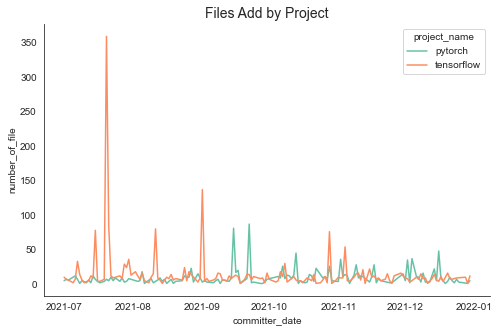

In [43]:
plt.figure(figsize=(8,5))
sns.lineplot(x="committer_date",y='number_of_file',hue='project_name', data=df_file_add)
plt.title("Files Add by Project",fontsize=14)
sns.despine()

##### The new file should be able to indicate the (creation stage/early stage) of development. From a chronological perspective, the development period of tensorflow is July 2021, and the development  period of pytorch is September 2021, which is consistent with the actual situation.

### 3.7.3: Files modified by date

In [44]:
sql="""
    select project_name, committer_date::date as committer_date,count(a.hash) as number_of_file
    from fcp.git_commit a 
    join fcp.git_commit_file b
    on a.hash=b.hash
    
    where project_name in('pytorch','tensorflow')
    and change_type='MODIFY'
    group by 1,2
    order by 1,2
"""

df_file_modify=pd.read_sql(sql,connection)
df_file_modify['committer_date']=pd.to_datetime(df_file_modify['committer_date'])
df_file_modify.head()

,project_name,committer_date,number_of_file
0,pytorch,2021-07-01,245
1,pytorch,2021-07-02,30
2,pytorch,2021-07-03,18
3,pytorch,2021-07-06,91
4,pytorch,2021-07-07,164


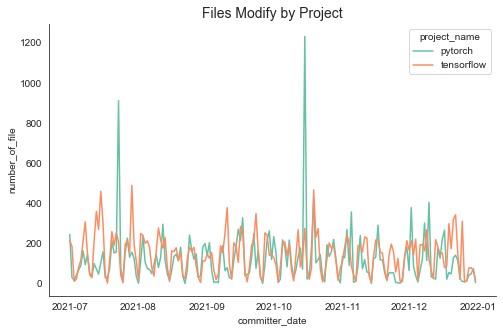

In [45]:
plt.figure(figsize=(8,5))
sns.lineplot(x="committer_date",y='number_of_file',hue='project_name', data=df_file_modify)
plt.title("Files Modify by Project",fontsize=14)
sns.despine()

###### assumption: we do not look at rename and delete

##### From the perspective of file modification, pytorch has undergone two major revisions in July 21 and October 21. It can be said that the development experience of Tensorflow was relatively smoother than that of Pytorch as the line graph of Tensorflow is less erratic than that of Pytorch's.

## 3.8 Issues

### 3.8.1: Number of Issues found by date

In [46]:
sql="""
    select project, created_at::date as created_at,count(a.issue_id) as number_of_issue
    from fcp.git_issue a 
    
    where project in('pytorch','tensorflow')
    group by 1,2
    order by 1,2
"""

df_issue=pd.read_sql(sql,connection)
df_issue['created_at']=pd.to_datetime(df_issue['created_at'])
df_issue.head()

,project,created_at,number_of_issue
0,pytorch,2016-08-16,1
1,pytorch,2016-08-26,1
2,pytorch,2016-09-02,1
3,pytorch,2016-10-19,1
4,pytorch,2016-11-27,1


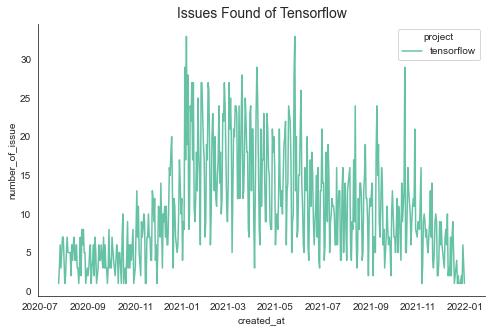

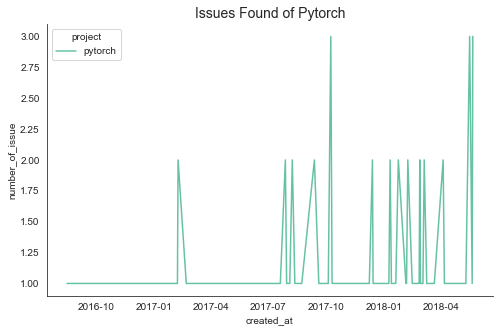

In [47]:
plt.figure(figsize=(8,5))
sns.lineplot(x="created_at",y='number_of_issue',hue='project', data=df_issue[df_issue['project']=='tensorflow'])
plt.title("Issues Found of Tensorflow",fontsize=14)
sns.despine()
plt.show()

plt.figure(figsize=(8,5))
sns.lineplot(x="created_at",y='number_of_issue',hue='project', data=df_issue[df_issue['project']=='pytorch'])
plt.title("Issues Found of Pytorch",fontsize=14)
sns.despine()
plt.show()

##### The data of the issue is mainly concerning tensorflow, and less about pytorch. We can see a trend where Tensorflow has a steady increase of issues throughout time and then a steady decline as well up till January 2021.
##### It is not clear whether pytorch itself has no issue after 18 years (unlikely), or the issue reporting mechanism has been terminated, or was data not collected in this regard.

### 3.8.2: Issues fix-time
#####  The average time it takes to resolve an issue

In [48]:
sql="""
    select project, created_at,closed_at,extract(epoch from (closed_at-created_at))::integer/3600 as hours
    from fcp.git_issue a 
    
    where project in('pytorch','tensorflow')
"""

df_issue_fix_hour=pd.read_sql(sql,connection)
df_issue_fix_hour.head()

,project,created_at,closed_at,hours
0,pytorch,2017-08-16 05:09:55,2021-01-11 04:38:15,29855
1,pytorch,2018-05-06 12:29:32,2021-08-12 23:26:10,28666
2,pytorch,2017-11-15 16:30:52,2018-01-16 19:50:47,1491
3,pytorch,2018-04-27 09:01:47,2021-01-10 08:49:58,23735
4,pytorch,2018-01-16 20:01:02,2021-09-06 08:28:40,31884


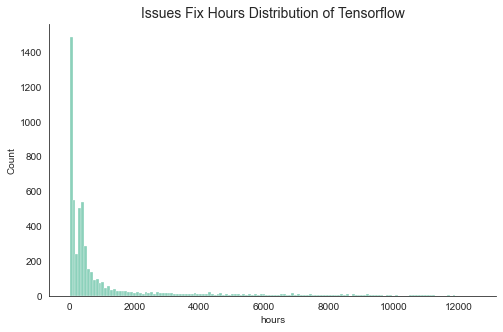

In [49]:
plt.figure(figsize=(8,5))
sns.histplot(x="hours", data=df_issue_fix_hour[df_issue_fix_hour['project']=='tensorflow'])
plt.title("Issues Fix Hours Distribution of Tensorflow",fontsize=14)
sns.despine()
plt.show()

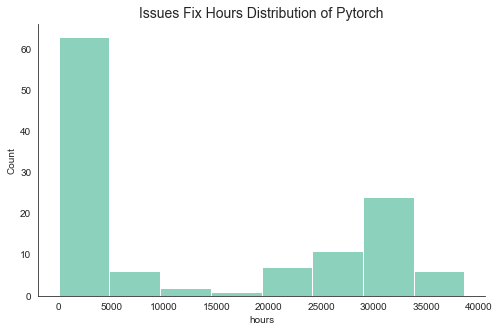

In [50]:
plt.figure(figsize=(8,5))
sns.histplot(x="hours", data=df_issue_fix_hour[df_issue_fix_hour['project']=='pytorch'])
plt.title("Issues Fix Hours Distribution of Pytorch",fontsize=14)
sns.despine()
plt.show()

##### Tensorflow hours of resolve on average is much shorter than Pytorch.
##### But note: pytorch data itself is relatively small, and we can't rule out that there is a problem with this data(bias). Generally speaking, it is unlikely that a problem will be fixed in a few years.

In [51]:
# Add another avg

sql="""
    select project, avg(extract(epoch from (closed_at-created_at))::integer/3600) as avg_hours
    , avg(extract(epoch from (closed_at-created_at))::integer/3600/24) as avg_days
    from fcp.git_issue a 
    where project in('pytorch','tensorflow')
    group by 1
"""

pd.read_sql(sql,connection)


,project,avg_hours,avg_days
0,pytorch,12724.308333,529.808333
1,tensorflow,1093.839236,45.137029


### 3.8.3: Users that report the most issues
##### Lets see which developers find more bugs

In [52]:
sql="""
select *
from
(
    select project, "user",count(issue_id) as number_of_issue
    ,rank()over(partition by project order by count(issue_id) desc) as rnk
    from fcp.git_issue
    where project in('pytorch','tensorflow')
    group by 1,2
) tmp
where rnk<=5
"""

df_top5_issue_finder=pd.read_sql(sql,connection)
df_top5_issue_finder.head()

,project,user,number_of_issue,rnk
0,pytorch,ezyang,4,1
1,pytorch,SsnL,3,2
2,pytorch,antspy,2,3
3,pytorch,glample,2,3
4,pytorch,soumith,2,3


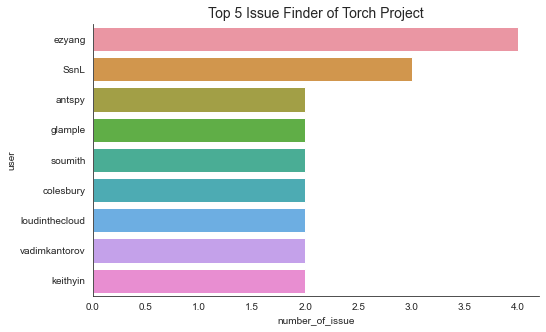

In [53]:
plt.figure(figsize=(8,5))
sns.barplot(y="user",x='number_of_issue', data=df_top5_issue_finder[df_top5_issue_finder["project"]=='pytorch'])
plt.title("Top 5 Issue Finder of Torch Project",fontsize=14)
sns.despine()

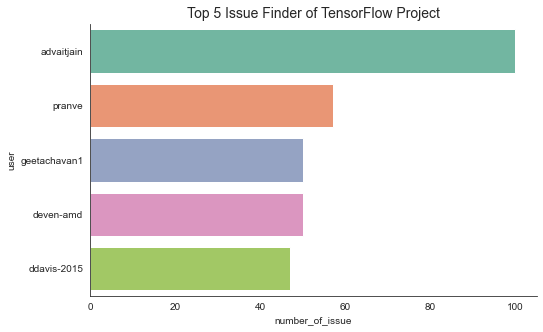

In [54]:
plt.figure(figsize=(8,5))
sns.barplot(y="user",x='number_of_issue', data=df_top5_issue_finder[df_top5_issue_finder["project"]=='tensorflow'])
plt.title("Top 5 Issue Finder of TensorFlow Project",fontsize=14)
sns.despine()

##### We can see a trend with both Tensorflow and Pytorch, there usually is one developer that finds the more issues than the other developers in both Tensorflow and Pytorch.

### 3.8.4: Users that close the most issues

In [55]:
sql="""
select *
from
(
    select project, closed_by,count(issue_id) as number_of_issue
    ,rank()over(partition by project order by count(issue_id) desc) as rnk
    from fcp.git_issue
    where project in('pytorch','tensorflow')
    and closed_by !='NaN'
    group by 1,2
) tmp
where rnk<=5
"""

df_top5_issue_closer=pd.read_sql(sql,connection)
df_top5_issue_closer.head()

,project,closed_by,number_of_issue,rnk
0,pytorch,Adam Paszke,25,1
1,pytorch,Soumith Chintala,22,2
2,pytorch,Mike Ruberry,19,3
3,pytorch,Facebook Community Bot,8,4
4,pytorch,Gary Miguel,8,4


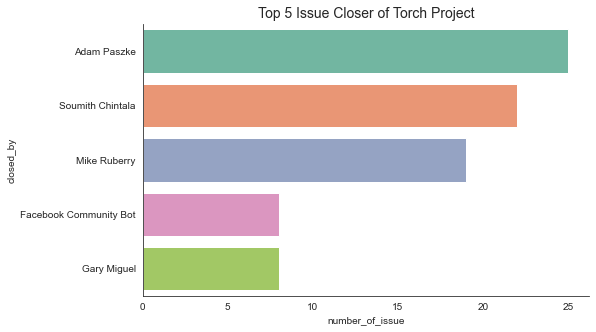

In [56]:
plt.figure(figsize=(8,5))
sns.barplot(y="closed_by",x='number_of_issue', data=df_top5_issue_closer[df_top5_issue_closer["project"]=='pytorch'])
plt.title("Top 5 Issue Closer of Torch Project",fontsize=14)
sns.despine()

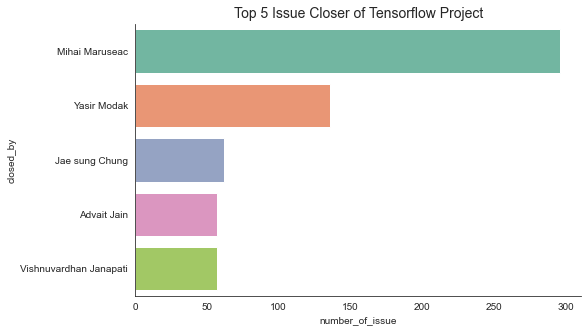

In [57]:
plt.figure(figsize=(8,5))
sns.barplot(y="closed_by",x='number_of_issue', data=df_top5_issue_closer[df_top5_issue_closer["project"]=='tensorflow'])
plt.title("Top 5 Issue Closer of Tensorflow Project",fontsize=14)
sns.despine()

##### For Tensorflow it is similar to part 3.8.3 where one developer closes / solves the most issues compared to the rest. Interestingly, for PyTorch there are 3 developers that close an almost equal amount of issues.

### 3.8.5: Top issue commenter

In [58]:
sql="""
select *
from
(
    select project, comment_user,count(comment_id) as number_of_comment
    ,rank()over(partition by project order by count(comment_id) desc) as rnk
    from fcp.git_issue a 
    join fcp.git_issue_comment b
    on a.issue_id=b.issue_id
    
    where project in('pytorch','tensorflow')
    group by 1,2
) tmp
where rnk<=5
"""

df_top5_issue_commenter=pd.read_sql(sql,connection)
df_top5_issue_commenter.head()

,project,comment_user,number_of_comment,rnk
0,pytorch,soumith,84,1
1,pytorch,apaszke,80,2
2,pytorch,ezyang,42,3
3,pytorch,kurtamohler,38,4
4,pytorch,mruberry,31,5


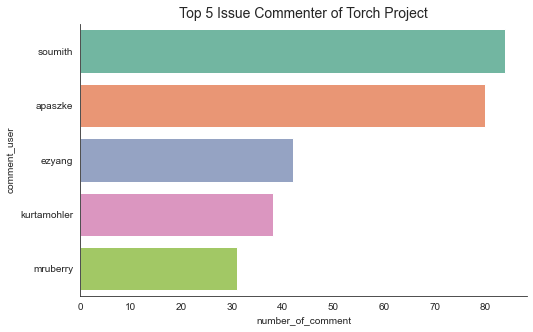

In [59]:
plt.figure(figsize=(8,5))
sns.barplot(y="comment_user",x='number_of_comment', data=df_top5_issue_commenter[df_top5_issue_commenter["project"]=='pytorch'])
plt.title("Top 5 Issue Commenter of Torch Project",fontsize=14)
sns.despine()

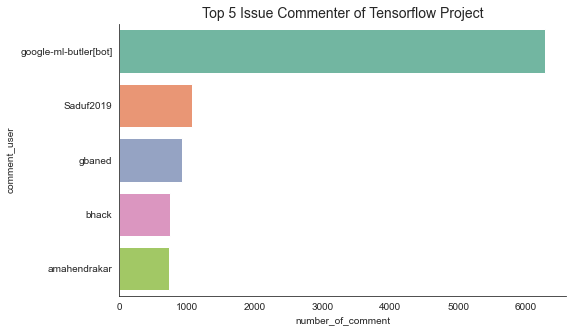

In [60]:
plt.figure(figsize=(8,5))
sns.barplot(y="comment_user",x='number_of_comment', data=df_top5_issue_commenter[df_top5_issue_commenter["project"]=='tensorflow'])
plt.title("Top 5 Issue Commenter of Tensorflow Project",fontsize=14)
sns.despine()

### 3.8.6: Top issue labels
##### Lets look at the label of these bugs

In [61]:
sql="""
select *
from
(
    select project,label,count(*) as number_of_issue
    ,rank()over(partition by project order by count(*) desc) as rnk
    from
    (
        select project, unnest(string_to_array(replace(replace(replace(replace(labels,' ',''),'''',''),'[',''),']',''),',')) as label
        from fcp.git_issue
        where project in('pytorch','tensorflow')
    )tmp
    group by 1,2
) tmp
where rnk<=10
"""

df_top5_issue_label=pd.read_sql(sql,connection)
df_top5_issue_label.head()

,project,label,number_of_issue,rnk
0,pytorch,triaged,43,1
1,pytorch,highpriority,11,2
2,pytorch,module:onnx,9,3
3,pytorch,feature,8,4
4,pytorch,opensource,7,5


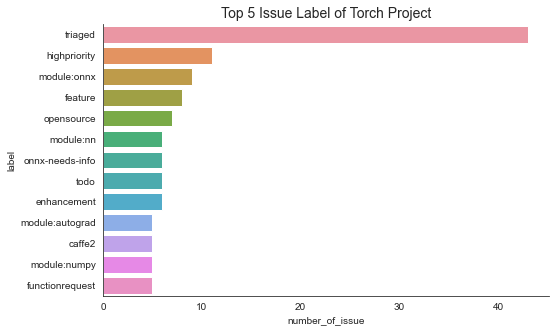

In [62]:
plt.figure(figsize=(8,5))
sns.barplot(y="label",x='number_of_issue', data=df_top5_issue_label[df_top5_issue_label["project"]=='pytorch'])
plt.title("Top 5 Issue Label of Torch Project",fontsize=14)
sns.despine()

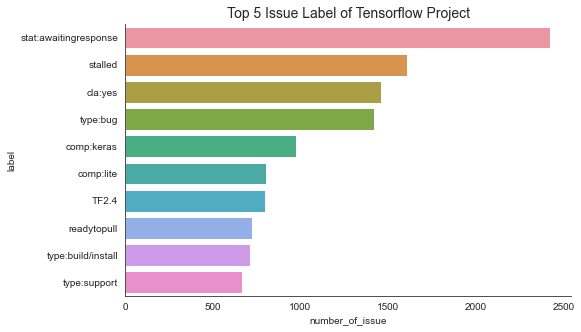

In [63]:
plt.figure(figsize=(8,5))
sns.barplot(y="label",x='number_of_issue', data=df_top5_issue_label[df_top5_issue_label["project"]=='tensorflow'])
plt.title("Top 5 Issue Label of Tensorflow Project",fontsize=14)
sns.despine()

# Part 4 (PySpark)
### *Task 3 of the assignment*
###### [Back to TOC](#table-of-contents)

##### Here we use pyspark for machine learning, to predict the upcoming weeks "issues" count for tensorflow
##### This is a regression model

In [64]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

pd.set_option("display.max_columns",None)
sns.set_palette('Set2')
sns.set_style('white')

In [65]:
spark = SparkSession.builder.appName('predict_project').getOrCreate()

## 4.1: Prepare weekly issue aggregation

In [66]:
sql="""
    select to_char(created_at::date,'IYYY-IW') as issue_week,count(a.issue_id) as number_of_issue
    from fcp.git_issue a 
    
    where project in('tensorflow')
    group by 1
    order by 1
"""

df_tf_weekly_issue=pd.read_sql(sql,connection)
df_tf_weekly_issue.head()

#2020-30 means week 30 of 2020
#Let's aggregate the data into weeks. daily fluctuation may be too large.

,issue_week,number_of_issue
0,2020-30,4
1,2020-31,33
2,2020-32,34
3,2020-33,33
4,2020-34,25


In [67]:
# the data is a bit small, but its enough to do a osl model

df_tf_weekly_issue.shape

(76, 2)

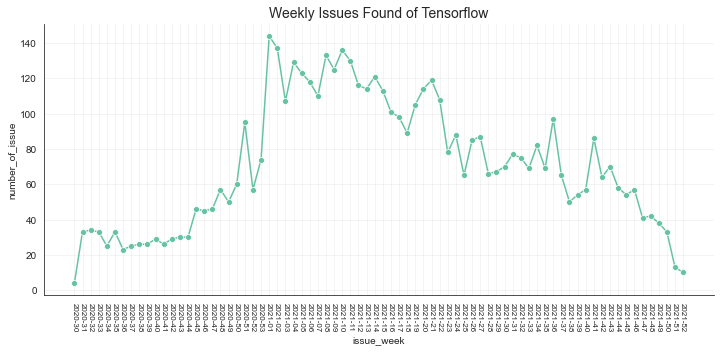

In [68]:
# plot issue trend

plt.figure(figsize=(12,5))
sns.lineplot(x="issue_week",y='number_of_issue',marker="o", data=df_tf_weekly_issue)
plt.title("Weekly Issues Found of Tensorflow",fontsize=14)
plt.xticks(rotation=-90,fontsize=8)
plt.grid(alpha=0.25)
sns.despine()
plt.show()

## 4.2: Prepare model dataset
+ We are using the number of issues in the past 5 weeks to predict the number of issues next week

In [69]:
# Use shift to generate the number of issues for the past 5 weeks as features

for i in range(1,6):
    df_tf_weekly_issue["n_issue_pre_{}".format(i)]=df_tf_weekly_issue["number_of_issue"].shift(i)
    
df_tf_weekly_issue=df_tf_weekly_issue.dropna()
df_tf_weekly_issue=df_tf_weekly_issue.rename(columns={'number_of_issue': 'label'})
df_tf_weekly_issue.head()

,issue_week,label,n_issue_pre_1,n_issue_pre_2,n_issue_pre_3,n_issue_pre_4,n_issue_pre_5
5,2020-35,33,25.0,33.0,34.0,33.0,4.0
6,2020-36,23,33.0,25.0,33.0,34.0,33.0
7,2020-37,25,23.0,33.0,25.0,33.0,34.0
8,2020-38,26,25.0,23.0,33.0,25.0,33.0
9,2020-39,26,26.0,25.0,23.0,33.0,25.0


## 4.3: Generating a feature vector

In [70]:
df=spark.createDataFrame(df_tf_weekly_issue)

vecAssembler = VectorAssembler(outputCol="features")
vecAssembler.setInputCols(["n_issue_pre_1", "n_issue_pre_2", "n_issue_pre_3", "n_issue_pre_4", "n_issue_pre_5"])

df=vecAssembler.transform(df)
                          
df.show(5)

+----------+-----+-------------+-------------+-------------+-------------+-------------+--------------------+
|issue_week|label|n_issue_pre_1|n_issue_pre_2|n_issue_pre_3|n_issue_pre_4|n_issue_pre_5|            features|
+----------+-----+-------------+-------------+-------------+-------------+-------------+--------------------+
|   2020-35|   33|         25.0|         33.0|         34.0|         33.0|          4.0|[25.0,33.0,34.0,3...|
|   2020-36|   23|         33.0|         25.0|         33.0|         34.0|         33.0|[33.0,25.0,33.0,3...|
|   2020-37|   25|         23.0|         33.0|         25.0|         33.0|         34.0|[23.0,33.0,25.0,3...|
|   2020-38|   26|         25.0|         23.0|         33.0|         25.0|         33.0|[25.0,23.0,33.0,2...|
|   2020-39|   26|         26.0|         25.0|         23.0|         33.0|         25.0|[26.0,25.0,23.0,3...|
+----------+-----+-------------+-------------+-------------+-------------+-------------+--------------------+
only showi

## 4.4: Fitting a linear regression model

In [71]:
lr = LinearRegression(regParam=0.0, solver="normal")
model = lr.fit(df)

In [72]:
# ols intercept coefficients

model.intercept,model.coefficients

(4.100936829227752, DenseVector([0.7008, 0.0167, 0.306, -0.0587, -0.024]))

## 4.5: Preparing prediction features
##### using the last 5 weeks as x, we use the model to predict the number of issues

In [73]:
df_tf_weekly_issue.tail(1)

,issue_week,label,n_issue_pre_1,n_issue_pre_2,n_issue_pre_3,n_issue_pre_4,n_issue_pre_5
75,2021-52,10,13.0,33.0,38.0,42.0,41.0


In [74]:
df_pred = spark.createDataFrame([(33,38,42,41,10)], ["n_issue_pre_1", "n_issue_pre_2", "n_issue_pre_3", "n_issue_pre_4", "n_issue_pre_5"])
df_pred=vecAssembler.transform(df_pred)
df_pred.show()

+-------------+-------------+-------------+-------------+-------------+--------------------+
|n_issue_pre_1|n_issue_pre_2|n_issue_pre_3|n_issue_pre_4|n_issue_pre_5|            features|
+-------------+-------------+-------------+-------------+-------------+--------------------+
|           33|           38|           42|           41|           10|[33.0,38.0,42.0,4...|
+-------------+-------------+-------------+-------------+-------------+--------------------+



In [75]:
model.setPredictionCol("newPrediction")
df_pred=model.transform(df_pred)
df_pred.show()

+-------------+-------------+-------------+-------------+-------------+--------------------+---------------+
|n_issue_pre_1|n_issue_pre_2|n_issue_pre_3|n_issue_pre_4|n_issue_pre_5|            features|  newPrediction|
+-------------+-------------+-------------+-------------+-------------+--------------------+---------------+
|           33|           38|           42|           41|           10|[33.0,38.0,42.0,4...|38.067064949417|
+-------------+-------------+-------------+-------------+-------------+--------------------+---------------+



##### Based on the data and the ols model, the number of issues of the tensoflow project in the coming week is 38